**What is Pneumonia ?**

From Mayo Clinic's Article on pneumonia

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

In [2]:
!pip install --upgrade tensorflow keras

In [3]:
from tensorflow import keras


In [4]:
import tensorflow as tf
print(tf.__version__)

2.18.0


**Step 1: Import Modules**

In [5]:
# System and Utilities
import os
import csv
import random
import zlib
import itertools
import warnings
from glob import glob
from tqdm import tqdm

# Data Handling & Processing
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.transform import resize
import skimage

# Machine Learning & Statistics
import scipy
import sklearn
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# ✅ Fix: Correct Import for TensorFlow & Keras
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
    from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.applications import VGG16, InceptionV3
except ModuleNotFoundError:
    print("⚠️ TensorFlow is not installed. Installing now...")
    !pip install tensorflow
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
    from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.applications import VGG16, InceptionV3

# Handling Imbalanced Data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Display images inline (for Jupyter Notebook)
%matplotlib inline

# Ignore warnings
warnings.filterwarnings("ignore")

# ✅ Check TensorFlow version
print(f"✔️ TensorFlow Version: {tf.__version__}")


✔️ TensorFlow Version: 2.18.0


**Step 2: Load Data**

In [6]:
import os
import cv2
import numpy as np
import skimage.transform
from tqdm import tqdm

def get_data(folder):
    X = []  # List to store images
    y = []  # List to store labels

    for folderName in os.listdir(folder):
        folder_path = os.path.join(folder, folderName)  # Correctly join paths
        if not os.path.isdir(folder_path):  # Ensure it's a directory
            continue

        if folderName == 'NORMAL':
            label = 0  # No pneumonia
        elif folderName == 'PNEUMONIA':
            label = 1  # Pneumonia
        else:
            continue  # Ignore unexpected folders

        for image_filename in tqdm(os.listdir(folder_path)):
            image_path = os.path.join(folder_path, image_filename)
            img_file = cv2.imread(image_path)

            if img_file is not None:
                img_file = skimage.transform.resize(img_file, (150, 150, 3))
                X.append(np.asarray(img_file))
                y.append(label)

    return np.asarray(X), np.asarray(y)

# Correct Paths
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"

X_train, y_train = get_data(train_dir)
X_test, y_test = get_data(test_dir)

# Encode labels to categorical vectors
from tensorflow.keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes=2)
y_testHot = to_categorical(y_test, num_classes=2)


100%|██████████| 390/390 [00:52<00:00,  7.41it/s]


**Step 3: Vizualize Data**

The min/max pixel values are already scaled between 0 and 1

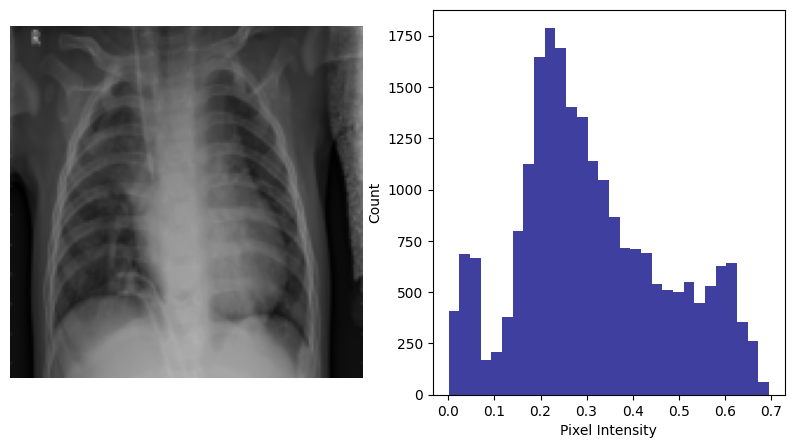

In [7]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

In [8]:
from glob import glob

multipleImages = glob('/content/drive/MyDrive/chest_xray/train/NORMAL')  # Adjust path
print("Found images:", len(multipleImages))  # Check how many images are found

Found images: 1


In [9]:
multipleImages = glob('/content/drive/MyDrive/chest_xray/train/NORMAL/*.jpg')  # Only JPG files
multipleImages += glob('/content/drive/MyDrive/chest_xray/train/NORMAL/*.png')  # Also add PNGs


Found 1343 images.


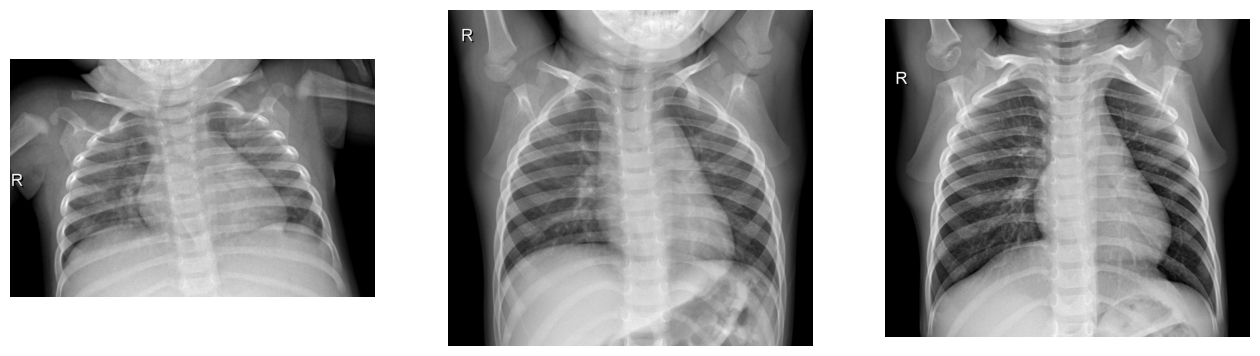

In [10]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Ensure the correct path format
multipleImages = glob('/content/drive/MyDrive/chest_xray/train/NORMAL/*.*')

# Filter for valid image formats
valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
multipleImages = [img for img in multipleImages if os.path.splitext(img)[1].lower() in valid_extensions]

# Debugging prints
print(f"Found {len(multipleImages)} images.")

def plotThreeImages(images):
    num_images = len(images)

    if num_images == 0:
        print("No images found. Check your dataset path.")
        return
    elif num_images < 3:
        print(f"Only {num_images} images found. Displaying all available images.")
        selected_images = images  # Use all available images
    else:
        selected_images = random.sample(images, 3)  # Randomly select 3 images

    plt.figure(figsize=(16, 16))
    for i, img_path in enumerate(selected_images):
        plt.subplot(1, len(selected_images), i + 1)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading image: {img_path}")
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis('off')

    plt.show()

# Call function
plotThreeImages(multipleImages)


**20 images from category "No Pneumonia"**

No Pneumonia


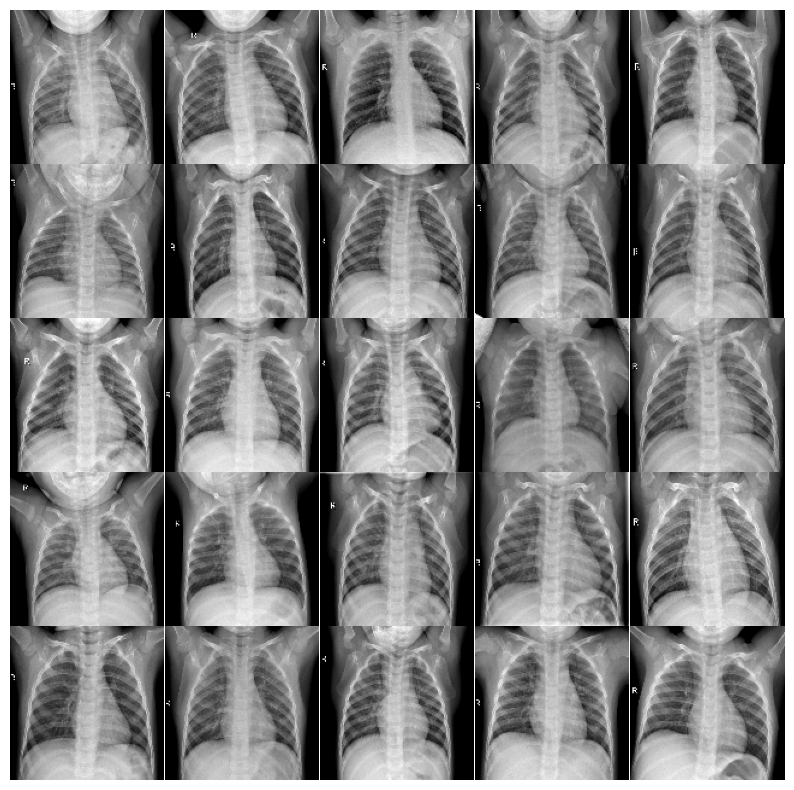

In [11]:
print("No Pneumonia")
multipleImages = glob('/content/drive/MyDrive/chest_xray/train/NORMAL/*.*')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128))
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1


**20 images from category "Yes Pneumonia"**

Yes Pneumonia


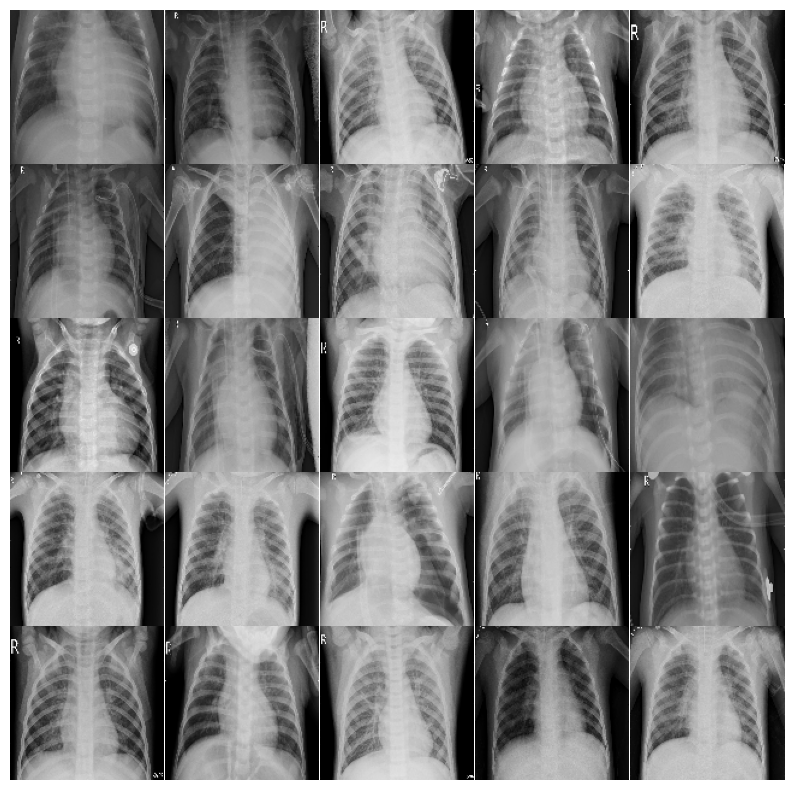

In [12]:
print("Yes Pneumonia")
multipleImages = glob('/content/drive/MyDrive/chest_xray/train/PNEUMONIA/*.*')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128))
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

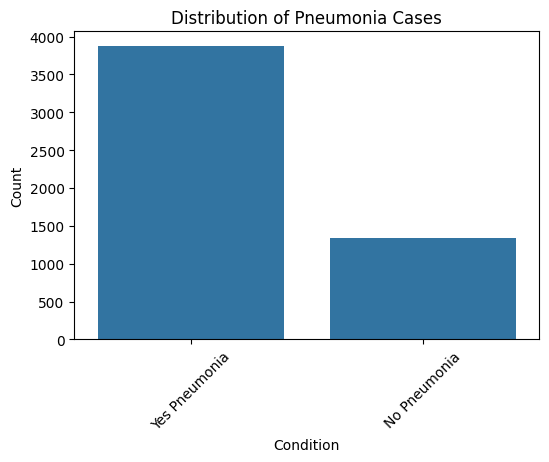

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Label Mapping
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}

# Create DataFrame
df = pd.DataFrame({"labels": y_train})

# Convert numeric labels to text labels
df["labels"] = df["labels"].map(map_characters)

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x=df["labels"], order=df["labels"].value_counts().index)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.xlabel("Condition")
plt.ylabel("Count")
plt.title("Distribution of Pneumonia Cases")

# Show plot
plt.show()

# Print dictionary for verification
print(map_characters)


**Step 4: Define Helper Functions**

In [14]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

**Step 5: Evaluate Classification Models**

Transfer learning w/ VGG16 Convolutional Network

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16, InceptionV3
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# Define labels
map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}

# Compute class weights
class_weight1 = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Load Pretrained Models (without top layer)
pretrained_model_1 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
pretrained_model_2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Define Optimizer
optimizer1 = keras.optimizers.RMSprop(learning_rate=0.0001)

# Function to Train Pretrained Models
def pretrainedNetwork(xtrain, ytrain, xtest, ytest, pretrainedmodel, pretrainedweights, classweight, numclasses, numepochs, optimizer, labels):
    # Load Base Model
    base_model = pretrainedmodel

    # Add Custom Top Layers
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Load Custom Weights (if provided)
    if pretrainedweights:
        base_model.load_weights(pretrainedweights)

    # Freeze Pretrained Layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Callbacks
    callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]

    # Model Summary
    model.summary()

    # Train Model
    history = model.fit(
        xtrain, ytrain,
        epochs=numepochs,
        class_weight=classweight,
        validation_data=(xtest, ytest),
        verbose=1,
        callbacks=callbacks_list
    )

    # Evaluate Model
    score = model.evaluate(xtest, ytest, verbose=0)
    print('\nKeras CNN - Accuracy:', score[1], '\n')

    # Predictions
    y_pred = model.predict(xtest)
    print('\n', classification_report(np.argmax(ytest, axis=1), np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='')

    # Confusion Matrix
    Y_pred_classes = np.argmax(y_pred, axis=1)
    Y_true = np.argmax(ytest, axis=1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

    # Plot Results
    plot_confusion_matrix(confusion_mtx, classes=list(labels.values()))
    plt.show()

    return model

# Example Usage:
# model = pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot, pretrained_model_1, None, class_weight1, 2, 3, optimizer1, map_characters1)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


**Transfer learning w/ InceptionV3 Convolutional Network**

In [16]:
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_2,weight_path2,class_weight1,2,3,optimizer1,map_characters1)

**Step 6: Evaluate Undersampling Strategy**

The goal is to get rid of the class imbalance issues. Oversampling with data augmentation (e.g. SMOTE) would be preferable to undersampling but undersampling is faster.

Class Distribution:
 labels
0    1343
1    1343
Name: count, dtype: int64


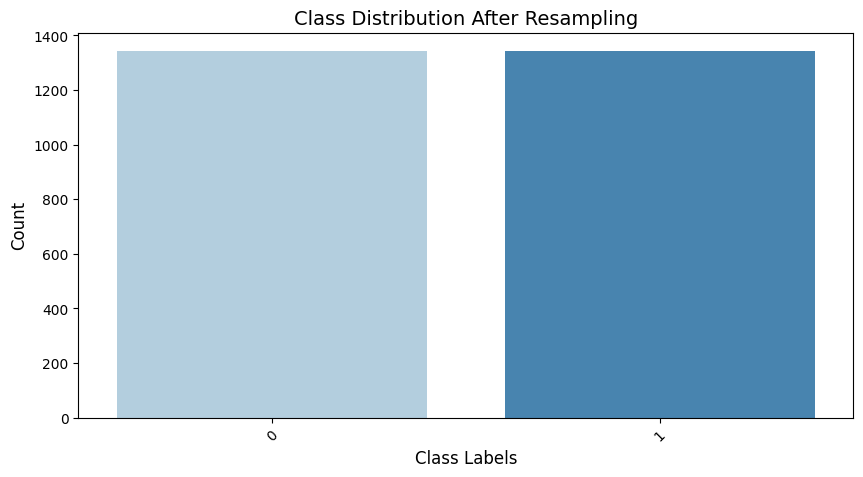

In [17]:
# Make Data 1D for compatibility with upsampling methods
X_trainShape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_testShape = X_test.shape[1] * X_test.shape[2] * X_test.shape[3]

X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

Y_train = y_train
Y_test = y_test

# Apply Random Under-Sampling
ros = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# Encode labels to one-hot vectors (e.g., 2 -> [0,1] if num_classes=2)
Y_trainRosHot = to_categorical(Y_trainRos, num_classes=2)
Y_testRosHot = to_categorical(Y_testRos, num_classes=2)

# Make Data 2D again (reshaping after resampling)
height, width, channels = 150, 150, 3
X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos), height, width, channels)
X_testRosReshaped = X_testRos.reshape(len(X_testRos), height, width, channels)

# Create a DataFrame for label distribution
dfRos = pd.DataFrame({"labels": Y_trainRos})

# Check class distribution before plotting
print("Class Distribution:\n", dfRos["labels"].value_counts())

# Plot Label Distribution
plt.figure(figsize=(10, 5))  # Adjust figure size
sns.countplot(x=dfRos["labels"], palette="Blues")
plt.xticks(rotation=45)  # Rotate for better readability
plt.title("Class Distribution After Resampling", fontsize=14)
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()


In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights before resampling
class_weight1 = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
print("Old Class Weights: ", dict(zip(np.unique(Y_train), class_weight1)))

# Compute class weights after resampling
class_weight2 = compute_class_weight(class_weight="balanced", classes=np.unique(Y_trainRos), y=Y_trainRos)
print("New Class Weights: ", dict(zip(np.unique(Y_trainRos), class_weight2)))


Old Class Weights:  {0: 1.9426656738644825, 1: 0.6732903225806451}
New Class Weights:  {0: 1.0, 1: 1.0}


**Step 7: Evaluate Final Model**

Transfer learning w/ VGG16 Convolutional Network

In [19]:
import os
print(os.path.exists("/content/drive/MyDrive/chest_xray.h5"))


False


In [20]:
class_weight1 = dict(enumerate(class_weight1))
class_weight2 = dict(enumerate(class_weight2))


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │          16,386 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,731,074 (56.19 MB)

 Trainable params: 16,386 (64.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 391ms/step - accuracy: 0.7751 - loss: 0.4606 - val_accuracy: 0.8889 - val_loss: 0.2846
Epoch 2/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 312ms/step - accuracy: 0.9454 - loss: 0.1323 - val_accuracy: 0.8440 - val_loss: 0.3632
Epoch 3/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - accuracy: 0.9585 - loss: 0.0986 - val_accuracy: 0.8184 - val_loss: 0.4502
Epoch 4/6
84/84 ━━━━━━━━━━━━━━━━━━━━ 28s 329ms/step - accuracy: 0.9705 - loss: 0.0747 - val_accuracy: 0.8205 - val_loss: 0.4706
Epoch 4: early stopping

Keras CNN - Accuracy: 0.8205128312110901 

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

               precision    recall  f1-score   support

 No Pneumonia       0.99      0.65      0.78       234
Yes Pneumonia       0.74      1.00      0.85       234

     accuracy                           0.82       468
    macro avg       0.87      0.82      0.81       468
 weighted avg       0.87      0.82      0.81       468



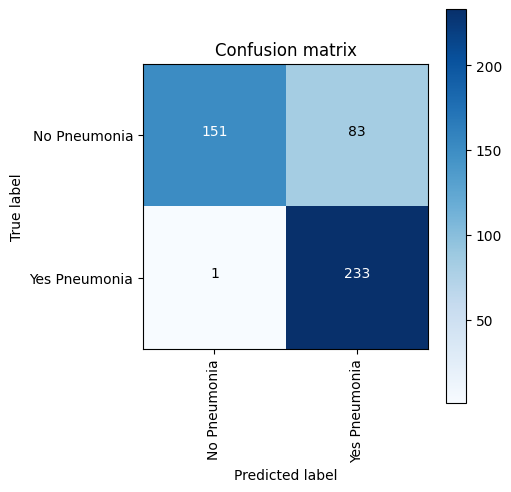

In [27]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

# Create a fresh optimizer instance
optimizer = Adam(learning_rate=0.001)

# Define the model
model = pretrainedNetwork(
    X_trainRosReshaped, Y_trainRosHot,
    X_testRosReshaped, Y_testRosHot,
    pretrained_model_1, None,  # Set pretrained weights to None if not needed
    class_weight1,  # Use dictionary format
    2, 6, optimizer, map_characters1
)

# Compile the model with the fresh optimizer
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


**We were able to detect pneumonia in x-ray images with an accuracy rate of approximately 85%. Great!**

To Do: (1) Add data augmentation; (2) Add ROC curve; (3)

**Performance evaluation**

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory paths (Update these paths if necessary)
train_dir = "/content/drive/MyDrive/chest_xray/train"  # Update this path to your dataset location
validation_dir = "/content/drive/MyDrive/chest_xray/val"  # Update if needed

# Data Augmentation and Image Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)  # Only rescale for validation

# Create Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="categorical"
)


Found 5218 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [35]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 126s 764ms/step - accuracy: 0.8924 - loss: 0.2498 - val_accuracy: 0.8750 - val_loss: 0.2197
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 658ms/step - accuracy: 0.9226 - loss: 0.1929 - val_accuracy: 0.8750 - val_loss: 0.2727
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 655ms/step - accuracy: 0.9433 - loss: 0.1604 - val_accuracy: 0.8750 - val_loss: 0.2484
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 107s 650ms/step - accuracy: 0.9426 - loss: 0.1550 - val_accuracy: 0.8750 - val_loss: 0.2272
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 106s 643ms/step - accuracy: 0.9374 - loss: 0.1557 - val_accuracy: 0.8125 - val_loss: 0.1852
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 640ms/step - accuracy: 0.9354 - loss: 0.1612 - val_accuracy: 0.8750 - val_loss: 0.2727
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 640ms/step - accuracy: 0.9416 - loss: 0.1425 - val_accuracy: 0.8750 - val_loss: 0.3305
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 634ms/step - accuracy: 0.9443 -

In [43]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Save the trained model
model.save('pneumonia_xray_model.h5')

# Get the keys of the history object
print(history.history.keys())


# Upload an image file for detection
uploaded = files.upload()

# Preprocess and predict
for filename in uploaded.keys():
    img_path = '/content/' + filename  # Ensure this path matches your environment
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    print(f"Filename: {filename}")

    # Check prediction probabilities for both classes
    if prediction[0][0] > prediction[0][1]:  # If probability of class 0 (No Pneumonia) is higher
        print("Report is Normal")
    else:
        print("Pneumonia Detected")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


Saving person9_bacteria_38.jpeg to person9_bacteria_38 (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Filename: person9_bacteria_38 (1).jpeg
Pneumonia Detected
